<a href="https://colab.research.google.com/github/Advanced-Data-Science-TU-Berlin/Part-2/blob/main/notebooks/1_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis
The data for this exercise is from a Kaggle dataset: https://www.kaggle.com/datasets/limkongkong/airpassengers

Firstly, we need to download the data from Kaggle using opendatasets Python package.
You need to have your Kaggle credential here to be able to download the file.
For further information you can check [here](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab#:~:text=To%20do%20this%2C%20go%20to,json%20to%20your%20computer.).

Here are the packages that we need in this exercise:

In [ ]:
!pip install opendatasets
!pip install pmdarima

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/limkongkong/airpassengers", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahnaznmz
Your Kaggle Key: ··········


100%|██████████| 764/764 [00:00<00:00, 429kB/s]

To start, let’s import the Pandas library and read the airline passenger data into a data frame:

In [ ]:
import pandas as pd 
df = pd.read_csv("/content/airpassengers/AirPassengers.csv")

Now, let’s display the first five rows of data using the data frame head() method:

In [ ]:
print(df.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


We can see that the data contains a column labeled “Month” that contains dates. In that column, the dates are formatted as year–month.

The second column is labeled “#Passengers,” and it contains the number of passengers for the year–month. Let’s take a look at the time interval of the data:

In [ ]:
print("Start Month:\t", df.Month.min())
print("End Month:\t", df.Month.max())

Start Month:	 1949-01
End Month:	 1960-12


The next thing we will want to do is convert the month column into a datetime object. This will allow it to programmatically pull time values like the year or month for each record. To do this, we use the Pandas to_datetime() method:

In [ ]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
print(df.head())

       Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121


Note that this process automatically inserts the first day of each month, which is basically a dummy value since we have no daily passenger data.

The next thing we can do is convert the month column to an index. This will allow us to more easily work with some of the packages we will be covering later:


In [ ]:
df.set_index('Month', inplace=True)
print(df.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Next, let’s generate a time series plot. This will allow us to visualize the time series data.

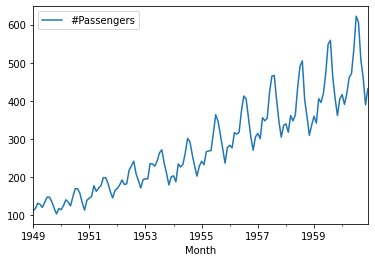

In [ ]:
df.plot()

# Stationarity
Stationarity is a key part of time series analysis. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. You should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

## Dickey Fuller Test

We will use the Dickey Fuller test to check for stationarity in our data. This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity.

These values allow us to test the degree to which present values change with past values. If there is no stationarity in the data set, a change in present values will not cause a significant change in past values.

Let’s test for stationarity in our airline passenger data. To start, let’s calculate a seven-month rolling mean:

In [ ]:
df.loc[:, 'rolling_mean_7'] = df['#Passengers'].rolling(7).mean()
df.loc[:, 'rolling_std_7'] = df['#Passengers'].rolling(7).std()

Next, let’s overlay our time series with the seven-month rolling mean and seven-month rolling standard deviation

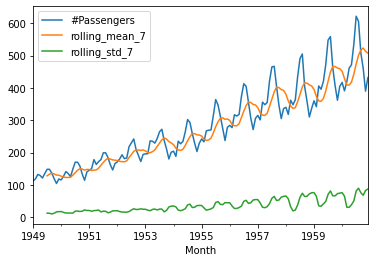

In [ ]:
df.plot()

## ADF Stationary Test
Next, let’s import the augmented Dickey-Fuller test from the statsmodels package. The documentation for the test can be found [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

In [ ]:
from statsmodels.tsa.stattools import adfuller

Next, let’s pass our data frame into the adfuller method. Here, we specify the autolag parameter as “AIC,” which means that the lag is chosen to minimize the information criterion:

In [ ]:
adft = adfuller(df['#Passengers'],autolag="AIC")

Next, let’s store our results in a data frame display it:

In [ ]:
test_output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
                               "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                         "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(test_output_df)

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the number of passengers.

# Autocorrelation
Checking for autocorrelation in time series data is another important part of the analytic process. This is a measure of how correlated time series data is at a given point in time with past values, which has huge implications across many industries. For example, if our passenger data has strong autocorrelation, we can assume that high passenger numbers today suggest a strong likelihood that they will be high tomorrow as well.

The Pandas data frame has an autocorrelation method that we can use to calculate the autocorrelation in our passenger data. Let’s do this for a one-month lag:

In [ ]:
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.9601946480498523


we can proceed to generate an autocorrelation visualization using statsmodel, and matplotlib. These modules have been abstracted to a great degree and this entire process can be done in only a few lines of code:

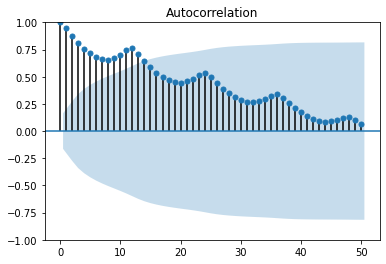

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(df[['#Passengers']], lags=50)
# Show the AR as a plot
plt.show()

This looks pretty interesting but ultimately doesn’t offer much utility without knowing how to read it! The blue shaded region is the confidence interval with a default value of α = 0.05. Anything within this range represents a value that has no significant correlation with the most recent value for the #passengers.

The vertical lines with markers at their tops are the “lags” that represent a specific number (50, in this case) of previous values. These represent the correlation value (shown on the y-axis) and diminish at a steady rate as their proximity from the recent number of passengers increases. That’s not the case with all data but certainly so with ours.

Notice that for a lag zero, ACF is always equal to one, which makes sense because the signal is always perfectly correlated with itself.


## Interpreting the Autocorrelation
This lets us know that previous number of passengers influence the current value but the significance of that influence decreases steadily with time. Specifically, values beyond the 14th previous day have no significant predictive power on the current number of passengers.

The strength of this relationship is measured on a scale of -1 to 1 when -1 being a 100% negative correlation and with a value of 1 being a 100% positive correlation. This measure is shown on the y-axis.

Further more, we can obviously see the 12-Month seasonality since the pattern of correlations repeat itself every 12 month.

# Decomposition
Trend decomposition is another useful way to visualize the trends in time series data. To proceed, let’s import seasonal_decompose from the statsmodels package:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

Next, let’s pass our data frame into the seasonal_decompose method and plot the result:



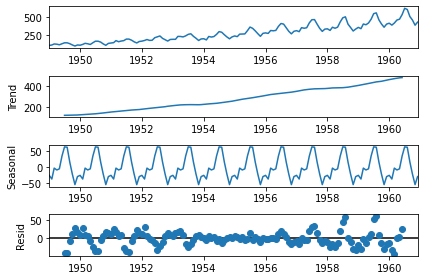

In [ ]:
decompose = seasonal_decompose(df[['#Passengers']].dropna(),model='additive')
decompose.plot()
plt.show()

From this plot, we can clearly see the increasing trend in number of passengers and the seasonality patterns in the rise and fall in values each year.

# Forecasting
Time series forecasting allows us to predict future values in a time series given current and past data. Here, we will use the ARIMA method to forecast the number of passengers, which allows us to forecast future values in terms of a linear combination of past values. We will use the auto_arima package, which will allow us to forgo the time consuming process of hyperparameter tuning.

First, let’s split our data for training and testing and visualize the split:

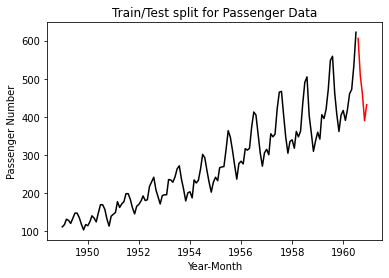

In [ ]:
df['Date'] = df.index
train = df.query("Date < '1960-08-01'")[['#Passengers']]
test = df.query("Date >= '1960-08-01'")[['#Passengers']]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
plt.show()

The black line corresponds to our training data and the red line corresponds to our test data.

# ARIMA Model Parameters
There are multiple approaches to set ARIMA parameters as they can be determined by either looking at the data properties or empirically by fitting the model and evaluating the performance. 

we need to determine the order of differencing “d.” by checking the autocorrelation plot. As we saw previously the original data is not ideal for the ARIMA model to directly start autoregressive training. So let’s see how the differencing and percentage change segment of ARIMA makes the data stationary.


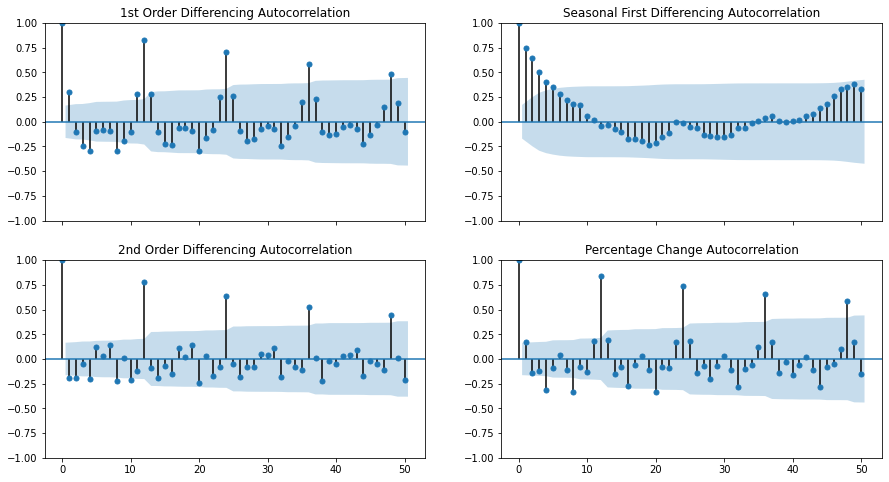

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(15,8))
# 1st Differencing
df['1st_difference'] = df['#Passengers'].diff()
plot_acf(df[['1st_difference']].dropna(), lags=50, ax=ax[0][0])
ax[0][0].set_title('1st Order Differencing Autocorrelation')
# 2nd Differencing
df['2nd_difference'] = df['#Passengers'].diff().diff()
plot_acf(df[['2nd_difference']].dropna(), lags=50, ax=ax[1][0])
ax[1][0].set_title('2nd Order Differencing Autocorrelation')
# Seasonal First Differencing
df['seasonal_first_difference'] = df['#Passengers'].diff(12)
plot_acf(df[['seasonal_first_difference']].dropna(), lags=50, ax=ax[0][1])
ax[0][1].set_title('Seasonal First Differencing Autocorrelation')
# Percentage Change
df['percentage_change'] = df['1st_difference']/df['#Passengers'].shift(1)
plot_acf(df[['percentage_change']].dropna(), lags=50, ax=ax[1][1])
ax[1][1].set_title('Percentage Change Autocorrelation')
plt.show()

As seen above, first-order differencing shakes up autocorrelation considerably and in the second order even more so we can consider the order of differencing (“d”) as 1

## Partial autocorrelation
In order to find the order of the AR term (p) we use the Partial autocorrelation Plot. Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


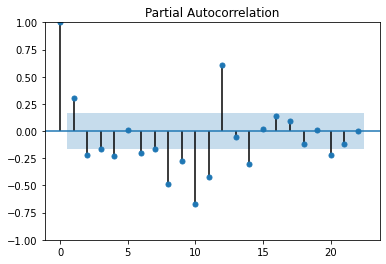

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['1st_difference'].dropna())
plt.show()

we see the first 2 lags are the most significant. Thus, we consider “p” to be 2.

Finally, “q” can be estimated similarly by looking at the ACF plot instead of the PACF plot. Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future. The ones with high correlation contribute more and would be enough to predict future values. From the plots above, the moving average (MA) parameter can be set to 2.

Thus, our final ARIMA model can be defined as ARIMA(p=2, d=1,q=2).

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['#Passengers'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.forecast(len(test), dynamic=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  139
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -645.554
Date:                Fri, 06 May 2022   AIC                           1301.107
Time:                        12:09:29   BIC                           1315.743
Sample:                    01-01-1949   HQIC                          1307.055
                         - 07-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7031      0.022     78.209      0.000       1.660       1.746
ar.L2         -0.9696      0.018    -54.478      0.000      -1.004      -0.935
ma.L1         -1.8391      0.705     -2.610      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


## How to Interpret ARIMA Model Results?
As seen above, the model summary provides several statistical measures to evaluate the performance of our model. Moreover, we also know the coefficient values for each of the parameters. As we kept the value of the MA parameter or “q” as 2, we have two trained coefficients for MA and one for AR.

Other than that we see the scores such as Akaike Information Critera (AIC), Bayesian Information Criterion (BIC), Hannan-Quinn Information Criterion (HQIC), and the standard deviation of innovations (innovations are the difference of the real value at time t and the predicted value at that time).

Now, let’s display the output of our model:

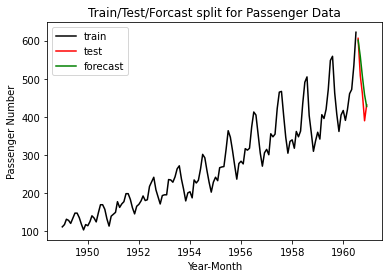

In [ ]:
plt.plot(train, color = "black", label='train')
plt.plot(test, color = "red", label='test')
plt.plot(forecast, color = 'green', label='forecast')
plt.title("Train/Test/Forcast split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
plt.legend()
plt.show()

Alternatively we can use auto_arima which searches for the best parameters for our ARIMA model. Let’s import auto_arima from the pdmarima package, train our model and generate predictions:

In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

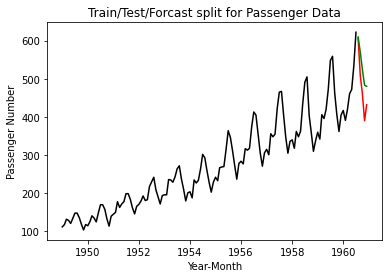

In [ ]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = 'green')
plt.title("Train/Test/Forcast split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
plt.show()

# How to Evaluate ARIMA Model in Python?
Beyond visual analysis, we can use various error measures and metrics to evaluate the performance of our ARIMA model in Python. 
For future use on a large number of predictions, we cannot evaluate the samples manually. We can use some of the many error metrics or Key Performance Indicators (KPI) available.
Some insightful performance error metrics such as root mean squared (RMSE), mean absolute error (MAE), mean percentage error (MPE), mean absolute percentage error (MAPE), correlation coefficient (to measure similarity), and min-max error.

In [ ]:
import numpy as np
rmse = np.mean((forecast.values - test['#Passengers'].values)**2)**.5 # RMSE
mae = np.mean(np.abs(forecast.values - test['#Passengers'].values)) # Mean Absolute Error
mpe = np.mean((forecast.values - test['#Passengers'].values)/test['#Passengers'].values) # Mean Percentage Error
mape = np.mean(np.abs(forecast.values - test['#Passengers'].values)/ \
               np.abs(test['#Passengers'].values)) # Mean Absolute Percentage Error
corr = np.corrcoef(forecast.values, test['#Passengers'])[0,1] # Correlation Coefficient
minmax = 1 - np.mean(np.minimum(forecast.values, test['#Passengers'].values)/ \
                     np.maximum(forecast.values, test['#Passengers'].values) )

In [ ]:
import pprint
pprint.pprint({'rmse':rmse, 'mae':mae, 'mpe':mpe, 'mape':mape,
               'corr':corr, 'minmax':minmax})

{'corr': 0.9155847217521993,
 'mae': 34.70298583337899,
 'mape': 0.07827649360359284,
 'minmax': 0.06950072701034116,
 'mpe': 0.07086312191057129,
 'rmse': 43.16207480443709}


However, these metrics are popular to measure errors in general regression models. In the case of time-series models, change in values over time, and metrics like MAE or MAPE do not easily capture the scale of the values. MAE finds the absolute difference between predicted and actual values and averages them over all samples in the test set. Over time, the change in values is lost, and the context of the set's actual values is also significant. For example, an MAE of 100 would be a good score if the actual values are of the order of 10,000s but a terrible score if the values lie in the hundreds. The same goes for RMSE. However, MAPE is scale-independent and is reliable for such a changing time series as long as the value never reaches 0 else, the score will be undefined. A better alternative is the mean absolute scaled error or MASE
<img width=300px src="https://dezyre.gumlet.io/images/blog/how-to-build-arima-model-in-python/image_459678857311641822385066.jpg?w=1100&dpr=1.0" />

MASE considers the data the model was trained on (ai) in the form of 1st order changes or differences. This makes it a good measure for time-series data irrespective of scale or time. We can implement it in Python as below

In [ ]:
n = len(train)
d = np.abs(np.diff(train['#Passengers'].values)).sum() / (n-1)
mase = mae / d
print("mase:", mase)

mase: 1.3986600598733354
